# work it out in numpy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
X = np.ones((200, 512))
d_model = 512
rows, cols = np.indices(X.shape)

In [2]:
rows, cols

(array([[  0,   0,   0, ...,   0,   0,   0],
        [  1,   1,   1, ...,   1,   1,   1],
        [  2,   2,   2, ...,   2,   2,   2],
        ...,
        [197, 197, 197, ..., 197, 197, 197],
        [198, 198, 198, ..., 198, 198, 198],
        [199, 199, 199, ..., 199, 199, 199]]),
 array([[  0,   1,   2, ..., 509, 510, 511],
        [  0,   1,   2, ..., 509, 510, 511],
        [  0,   1,   2, ..., 509, 510, 511],
        ...,
        [  0,   1,   2, ..., 509, 510, 511],
        [  0,   1,   2, ..., 509, 510, 511],
        [  0,   1,   2, ..., 509, 510, 511]]))

In [3]:
numerator = np.where(cols % 2, np.cos(rows), np.sin(rows))
denominator = (10_000**((2*cols)/d_model))
encodings = numerator / denominator
encodings.shape

(200, 512)

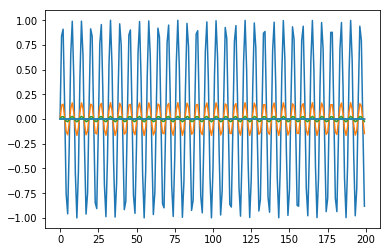

In [4]:
# sinusoids along each dimmension of the encoding
for encoding in encodings.T[::50]:
    plt.plot(encoding)

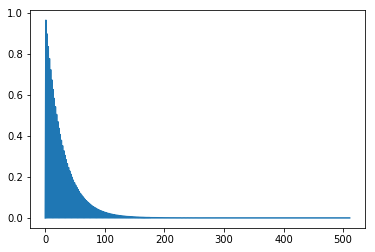

In [5]:
plt.plot(encodings[0])

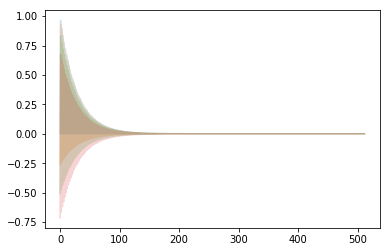

In [6]:
for encoding in encodings[::50]:
    plt.plot(encoding, alpha=0.2)

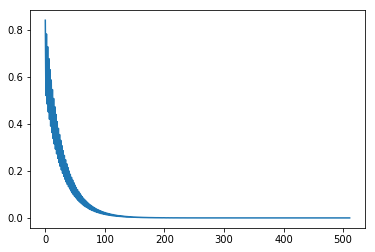

In [7]:
plt.plot(encodings[1])

# Now in keras

In [8]:
import keras.backend as K
import tensorflow as tf
from keras.layers import Embedding, Input, Lambda

Using TensorFlow backend.


In [9]:
input_ = Input(shape=(None,))

In [10]:
embedding = Embedding(input_dim=10, output_dim=512)(input_)

In [11]:
embedding

<tf.Tensor 'embedding_1/embedding_lookup:0' shape=(?, ?, 512) dtype=float32>

In [12]:
embedding.shape

TensorShape([Dimension(None), Dimension(None), Dimension(512)])

## mimic np.indices

In [13]:
def indices(n_rows, n_cols):
    rows = K.arange(n_rows)
    cols = K.arange(n_cols)
    col_indices = K.reshape(K.tile(cols, [n_rows]), (n_rows, n_cols))
    row_indices = K.transpose(K.reshape(K.tile(rows, [n_cols]), (n_cols, n_rows)))
    return row_indices, col_indices

In [14]:
K.eval(K.variable(10, dtype='int32'))

10

In [15]:
rows, cols = indices(200, 512)

In [16]:
K.eval(rows), K.eval(cols)

(array([[  0,   0,   0, ...,   0,   0,   0],
        [  1,   1,   1, ...,   1,   1,   1],
        [  2,   2,   2, ...,   2,   2,   2],
        ...,
        [197, 197, 197, ..., 197, 197, 197],
        [198, 198, 198, ..., 198, 198, 198],
        [199, 199, 199, ..., 199, 199, 199]], dtype=int32),
 array([[  0,   1,   2, ..., 509, 510, 511],
        [  0,   1,   2, ..., 509, 510, 511],
        [  0,   1,   2, ..., 509, 510, 511],
        ...,
        [  0,   1,   2, ..., 509, 510, 511],
        [  0,   1,   2, ..., 509, 510, 511],
        [  0,   1,   2, ..., 509, 510, 511]], dtype=int32))

In [17]:
# try it with uknown dimmension
row_shape = K.shape(embedding)[1]
col_shape = K.shape(embedding)[2]
print(row_shape, col_shape)
rows, cols = indices(row_shape, col_shape)
rows, cols

Tensor("strided_slice:0", shape=(), dtype=int32) Tensor("strided_slice_1:0", shape=(), dtype=int32)


(<tf.Tensor 'transpose_1:0' shape=(?, ?) dtype=int32>,
 <tf.Tensor 'Reshape_2:0' shape=(?, ?) dtype=int32>)

# try stacking it on top of the word embeddings

In [18]:
def f(X):
    sequence_dim = K.shape(X)[1]
    word_vector_dim = K.shape(X)[2]
    rows, cols = indices(sequence_dim, word_vector_dim)
    rows, cols = K.cast(rows, dtype='float32'), K.cast(cols, dtype='float32')
    numerator = K.switch(cols % 2, K.sin(rows), K.cos(rows))
    denominator = 10_000**((2*cols)/d_model)
    return X + (numerator / denominator)
L = Lambda(f, output_shape=lambda x: x)

In [19]:
x = L(embedding)

In [20]:
from keras.models import Model
model = Model(inputs=[input_], outputs=x)

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 512)         5120      
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 512)         0         
Total params: 5,120
Trainable params: 5,120
Non-trainable params: 0
_________________________________________________________________


In [22]:
X = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
    [1, 5, 9],
])
model.predict(X)

array([[[ 0.9648015 , -0.03565812,  0.8814145 , ...,  0.02931949,
         -0.01351134,  0.04814658],
        [ 0.5249927 ,  0.7927324 ,  0.5501462 , ...,  0.02647344,
          0.04763766,  0.01679583],
        [-0.3776661 ,  0.8945566 , -0.37572998, ...,  0.02279619,
         -0.04396033,  0.03014999]],

       [[ 1.0162258 , -0.03346106,  0.9383696 , ...,  0.02319379,
          0.01969949,  0.01720507],
        [ 0.5668043 ,  0.805881  ,  0.49836004, ...,  0.04347461,
          0.0342801 , -0.03453659],
        [-0.44213575,  0.84193796, -0.36062872, ..., -0.00127433,
         -0.02086121,  0.00434997]],

       [[ 1.0454814 ,  0.01162397,  0.9744472 , ..., -0.03007845,
          0.02083629,  0.04387567],
        [ 0.5281456 ,  0.7839749 ,  0.47837058, ..., -0.02553134,
         -0.0373943 ,  0.00112561],
        [-0.43653506,  0.90542555, -0.42754343, ...,  0.03419856,
         -0.02662899, -0.03229205]],

       [[ 0.9648015 , -0.03565812,  0.8814145 , ...,  0.02931949,
         -

# look at positional encodings only

In [23]:
i = Input(shape=(None, None,))

In [24]:
model = Model(inputs=[i], outputs=[L(i)])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None)        0         
_________________________________________________________________
lambda_1 (Lambda)            multiple                  0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [30]:
p = model.predict(np.zeros((1, 30, 512)))
p

array([[[ 1.00000000e+00,  0.00000000e+00,  9.30572033e-01, ...,
          0.00000000e+00,  1.07460778e-08,  0.00000000e+00],
        [ 5.40302277e-01,  8.11734736e-01,  5.02790153e-01, ...,
          9.37376665e-09,  5.80613024e-09,  8.72296546e-09],
        [-4.16146815e-01,  8.77164364e-01, -3.87254596e-01, ...,
          1.01293356e-08, -4.47194592e-09,  9.42607681e-09],
        ...,
        [-2.92138815e-01,  9.22579229e-01, -2.71856219e-01, ...,
          1.06537783e-08, -3.13934634e-09,  9.91410865e-09],
        [-9.62605834e-01,  2.61332422e-01, -8.95774066e-01, ...,
          3.01781977e-09, -1.03442375e-08,  2.80829870e-09],
        [-7.48057544e-01, -6.40182137e-01, -6.96121395e-01, ...,
         -7.39270822e-09, -8.03868438e-09, -6.87944768e-09]]],
      dtype=float32)

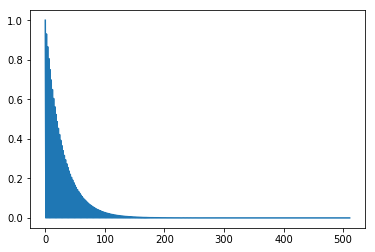

In [31]:
plt.plot(p[0][0])